In [1]:
import warnings
import numpy as np
print("connected to server")
import torch
import matplotlib.pyplot as plt

from visualizer import get_local
from transformers import AutoModel, AutoTokenizer
from datasets import load_dataset

connected to server


Loading Model and Dataset

In [ ]:
device = 'cuda:1'

get_local.activate() # 在引入模型之前，激活装饰器
model_path = "../model_cache"
model = AutoModel.from_pretrained(model_path, trust_remote_code=True, torch_dtype=torch.bfloat16).to(device).eval()
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)

In [2]:
gsm8k_dataset = load_dataset('openai/gsm8k', 'main')
# minerva_math_dataset = load_dataset('math-ai/minervamath')
# gpqa_dataset = load_dataset('math-ai/gpqa')
# mmlu_dataset_us_history = load_dataset('cais/mmlu', 'high_school_us_history')
# arc_dataset_challenge = load_dataset('allenai/ai2_arc', 'ARC-Challenge')

In [3]:
gsm8k_dataset['test']


Dataset({
    features: ['question', 'answer'],
    num_rows: 1319
})

In [ ]:
# minerva_math_dataset['test']

In [ ]:
# gpqa_dataset['test']

Absolute Positional Weights

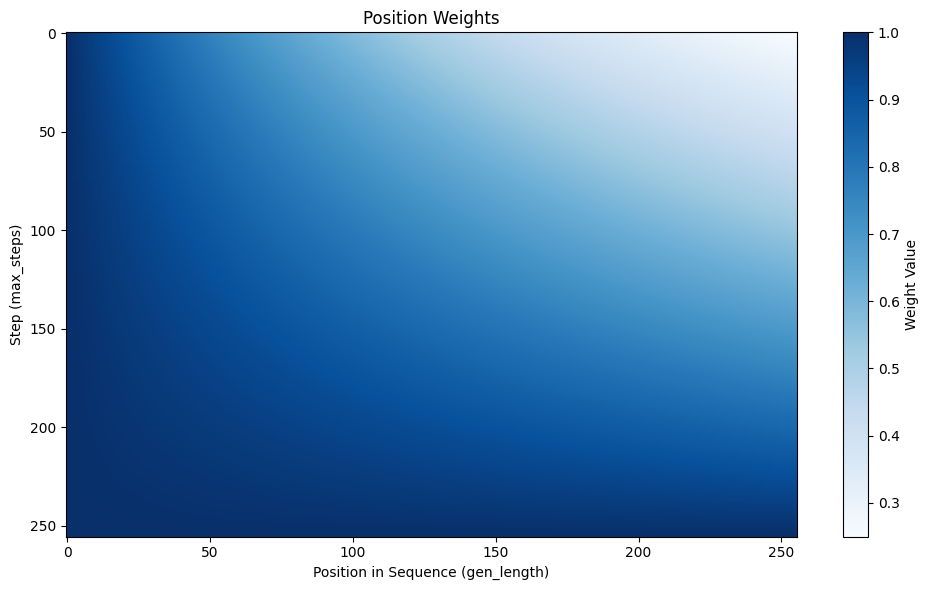

In [4]:
from sampler.utils import _precompute_positional_weights

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

position_weights = _precompute_positional_weights(
    max_steps=256,
    gen_length=256,
    max_weight=1.0,
    initial_min_weight=0.25,
    device=DEVICE
)

data_to_plot = position_weights.cpu().numpy()

fig, ax = plt.subplots(figsize=(10, 6))
# cmap='Blues' 是一个很好的单色选项，也可以换成 'Greys', 'Greens', 'Reds' 等
im = ax.imshow(data_to_plot, cmap='Blues', aspect='auto')

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Weight Value')

ax.set_title('Position Weights')
ax.set_xlabel('Position in Sequence (gen_length)')
ax.set_ylabel('Step (max_steps)')

plt.tight_layout()

plt.show()


Dynamic NMS

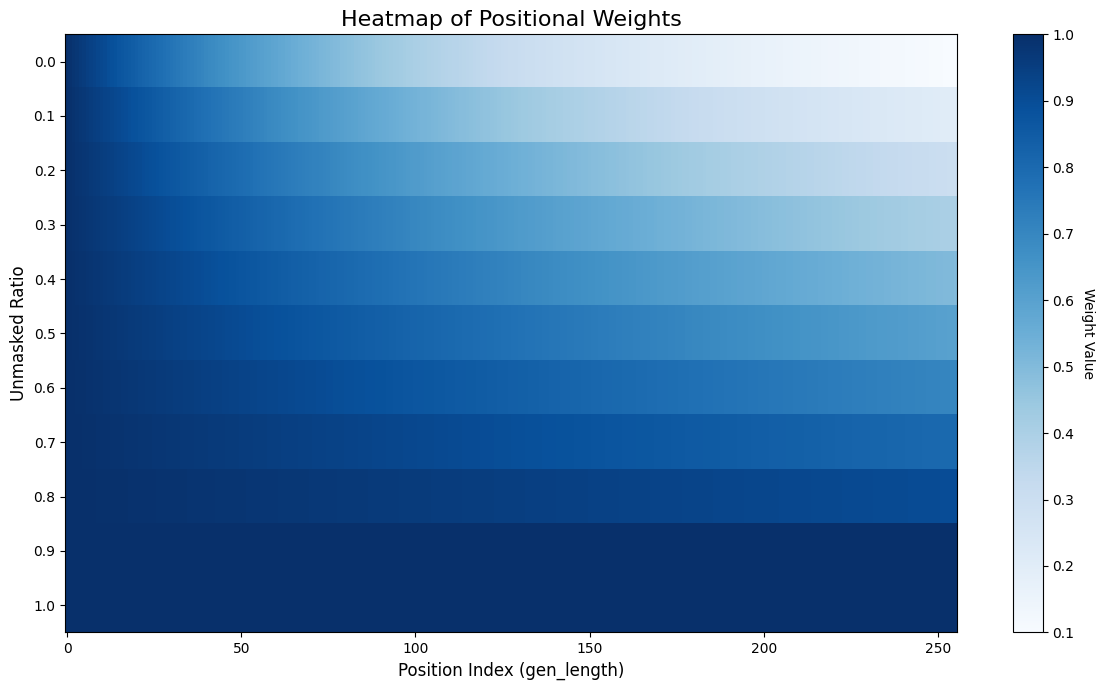

In [5]:
def compute_dynamic_positional_weights_np(
    gen_length: int,
    unmasked_ratio: float,
    max_weight: float = 1.0,
    initial_min_weight: float = 0.1,
    ur_factor: float = 1.0,
    dtype: np.dtype = np.float32
) -> np.ndarray:
    """
    根据 unmasked_ratio 计算当前步骤的权重向量，形状为 (gen_length,)。
    这是用于绘图的 NumPy 版本。
    """
    # 如果长度为1，直接返回最大权重
    if gen_length == 1:
        return np.full((gen_length,), max_weight, dtype=dtype)

    positions = np.arange(gen_length, dtype=dtype)
    min_weight = min(1.0, initial_min_weight + ur_factor * unmasked_ratio)
    lambda_decay = -np.log(min_weight) / (gen_length - 1)
    ratio_positional_weights = np.exp(-lambda_decay * positions)

    return ratio_positional_weights

# plot
gen_length = 256
unmasked_ratios = np.arange(0, 1.1, 0.1)

heatmap_data = np.array([
    compute_dynamic_positional_weights_np(gen_length, ur)
    for ur in unmasked_ratios
])

fig, ax = plt.subplots(figsize=(12, 7))
im = ax.imshow(heatmap_data, aspect='auto', cmap='Blues', origin='upper')

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Weight Value', rotation=270, labelpad=15)

ax.set_title('Heatmap of Positional Weights', fontsize=16)
ax.set_xlabel('Position Index (gen_length)', fontsize=12)
ax.set_ylabel('Unmasked Ratio', fontsize=12)

ax.set_yticks(np.arange(len(unmasked_ratios)))
ax.set_yticklabels([f'{ur:.1f}' for ur in unmasked_ratios])
plt.tight_layout()
plt.show()


Soft NMS

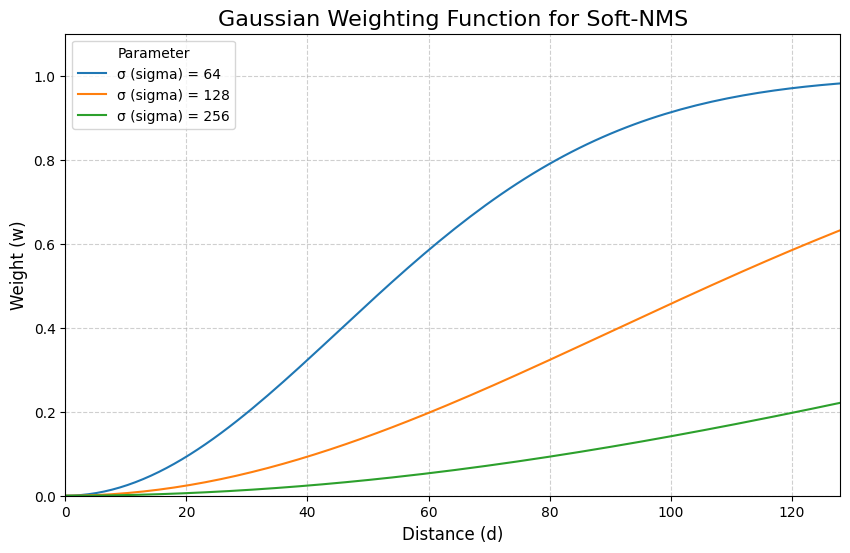

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def gaussian_weights(d, sigma):
    """
    计算高斯权重函数
    w(d) = exp(-d^2 / sigma^2)
    """
    return 1 - np.exp(-np.power(d, 2) / (sigma**2))

# 1. 定义距离范围 (x轴)
distances = np.linspace(0, 256, 200) # 生成200个点以绘制平滑曲线

# 2. 设置不同的 sigma 值进行对比
sigmas = [64, 128, 256]

# 3. 创建图形
plt.figure(figsize=(10, 6))

# 4. 对每个 sigma 值进行计算和绘图
for sigma in sigmas:
    weights = gaussian_weights(distances, sigma)
    plt.plot(distances, weights, label=f'σ (sigma) = {sigma}')

# 5. 设置图形的样式和标签
plt.title('Gaussian Weighting Function for Soft-NMS', fontsize=16)
plt.xlabel('Distance (d)', fontsize=12)
plt.ylabel('Weight (w)', fontsize=12)
plt.legend(title='Parameter', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(0, 1.1) # 设置y轴范围，让图形更清晰
plt.xlim(0, 128) # 设置x轴范围

# 6. 显示图形
plt.show()

Pure e^(-λx)

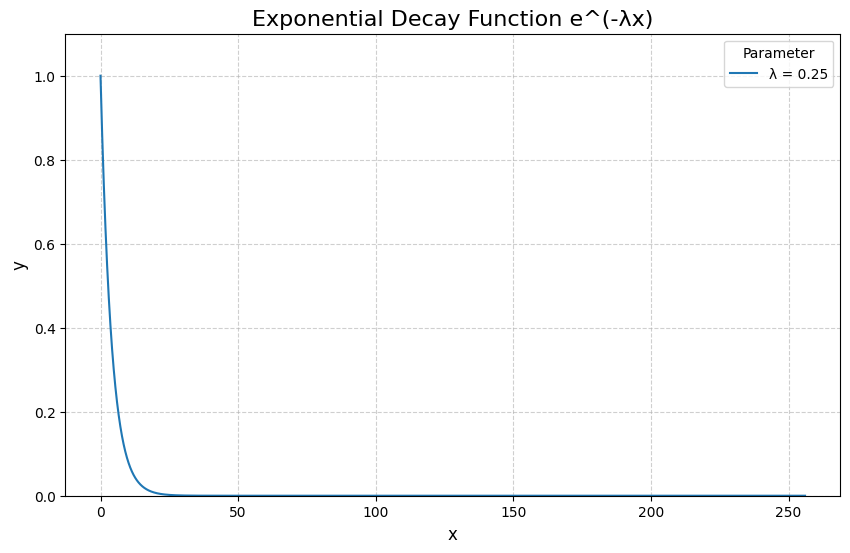

In [14]:
import numpy as np
import matplotlib.pyplot as plt


x = np.linspace(0, 256, 2560)  # 生成256个点以绘制平滑曲线

lambda_ = 0.25

plt.figure(figsize=(10, 6))

y = np.exp(-lambda_ * x)
plt.plot(x, y, label=f'λ = {lambda_}')

plt.title('Exponential Decay Function e^(-λx)', fontsize=16)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.legend(title='Parameter', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(0, 1.1)  # 设置y轴范围

# 6. 显示图形
plt.show()

In [16]:
#cos backfire

SyntaxError: invalid syntax (2652030148.py, line 1)

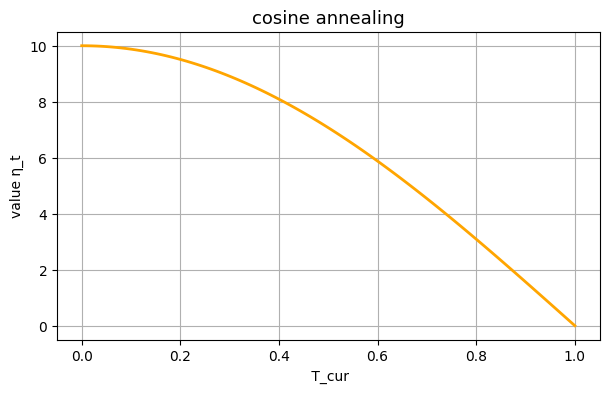

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# 参数设置
eta_max = 10
eta_min = 1
T_max = 1
T_cur = np.linspace(0, 1, 100)

# 改进余弦退火公式
eta_t = eta_max * (np.cos(np.pi/2 * (T_cur / T_max)))

# 绘图
plt.figure(figsize=(7, 4))
plt.plot(T_cur, eta_t, color='orange', linewidth=2)
plt.title("cosine annealing", fontsize=13)
plt.xlabel(" T_cur")
plt.ylabel("value η_t")
plt.grid(True)
plt.show()
